# Dirichlet-Multinomial Analysis of Costimulatory Domains

This notebook applies the Dirichlet-Multinomial (DM) model to the CAR:Raji condition.
The DM model correctly accounts for the compositional structure of FACS-partitioned data.

## Optional Data Sources

This analysis supports two optional data sources that can improve inference:

1. **FACS cell counts per IPSF**: Total cells sorted into each immunophenotypic subfraction.
   - Used to weight observations by actual cell numbers (vs sequencing depth)
   
2. **Starting distribution**: Sequencing counts from unsorted CAR+ cells.
   - Used as a prior for baseline CCD frequencies before phenotype-specific effects

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

import costim_screen as cs

## Define Paths to Data and Results

In [2]:
base_path = Path('.').resolve().parent
data_path = base_path / 'data'
results_path = base_path / 'results' / 'dm_analysis'
results_path.mkdir(parents=True, exist_ok=True)

# =============================================================================
# CONFIGURATION FLAGS - Set these to enable optional data sources
# =============================================================================

# FACS cell counts per IPSF (immunophenotypic subfraction)
# If True, weights observations by actual cell counts rather than sequencing depth
USE_FACS_CELL_COUNTS = False
FACS_CELL_COUNTS_PATH = data_path / '20240522 - costim pool sorted cells.xlsx'

# Starting distribution (unsorted CAR+ cells)
# If True, uses starting frequencies as a prior for baseline CCD distribution
USE_STARTING_DISTRIBUTION = False
STARTING_DISTRIBUTION_PATH = None  # Set to path of starting distribution counts

# =============================================================================
# Standard data paths
# =============================================================================
candidate_metadata_path = data_path / 'candidate_metadata.xlsx'
counts_path = data_path / 'merged_counts.xlsx'
elm_annotation_path = data_path / 'costim_normalized_elms_groupings.xlsx'
sample_metadata_path = data_path / 'sample_metadata.xlsx'
topology_metadata_path = data_path / 'costim_topol_protein_families.xlsx'

print(f"Data path: {data_path}")
print(f"Results path: {results_path}")
print()
print("Optional data sources:")
print(f"  USE_FACS_CELL_COUNTS: {USE_FACS_CELL_COUNTS}")
if USE_FACS_CELL_COUNTS:
    print(f"    Path: {FACS_CELL_COUNTS_PATH}")
    print(f"    Exists: {FACS_CELL_COUNTS_PATH.exists()}")
print(f"  USE_STARTING_DISTRIBUTION: {USE_STARTING_DISTRIBUTION}")
if USE_STARTING_DISTRIBUTION:
    print(f"    Path: {STARTING_DISTRIBUTION_PATH}")
    print(f"    Exists: {STARTING_DISTRIBUTION_PATH.exists() if STARTING_DISTRIBUTION_PATH else 'N/A'}")

Data path: /Users/cordessf/Library/CloudStorage/OneDrive-Personal/ACI/Repositories/CostimScreen/data
Results path: /Users/cordessf/Library/CloudStorage/OneDrive-Personal/ACI/Repositories/CostimScreen/results/dm_analysis

Optional data sources:
  USE_FACS_CELL_COUNTS: False
  USE_STARTING_DISTRIBUTION: False


## Load Inputs

In [3]:
counts_wide = cs.load_counts_matrix(counts_path, candidate_id_col="CandidateID")
smeta = cs.load_sample_metadata(sample_metadata_path)
cand = cs.load_candidate_metadata(candidate_metadata_path)

# Align IDs and columns
common_candidates = counts_wide.index.intersection(cand.index)
common_samples = counts_wide.columns.intersection(smeta.index)

counts_wide = counts_wide.loc[common_candidates, common_samples]
cand = cand.loc[common_candidates]
smeta = smeta.loc[common_samples]

print(f"Counts: {counts_wide.shape[0]} CCDs × {counts_wide.shape[1]} samples")
print(f"Candidates: {len(cand)}")
print(f"Samples: {len(smeta)}")

Counts: 1071 CCDs × 144 samples
Candidates: 1071
Samples: 144


## Load Optional Data Sources

In [4]:
# =============================================================================
# Load FACS cell counts per IPSF (if enabled)
# =============================================================================
facs_cell_counts = None

if USE_FACS_CELL_COUNTS and FACS_CELL_COUNTS_PATH and FACS_CELL_COUNTS_PATH.exists():
    print("Loading FACS cell counts...")
    facs_raw = pd.read_excel(FACS_CELL_COUNTS_PATH)
    
    # Parse the FACS data into a usable format
    # Columns: Sample, Exp Cond, HV (donor), T subset, PD1 Status, Replicate, Number
    facs_raw["Tsubset"] = facs_raw["T subset"].replace({"Naïve": "Naive"})
    facs_raw["phenotype"] = facs_raw["Tsubset"] + "_" + facs_raw["PD1 Status"]
    facs_raw["Donor"] = facs_raw["HV"]
    facs_raw["ExpCond"] = facs_raw["Exp Cond"].str.replace(" ", "").str.replace(":", ":")
    
    # Create CCR identifier to match the main data
    facs_raw["CCR"] = (
        facs_raw["Donor"].astype(str) + "_" + 
        facs_raw["ExpCond"] + "_r" + 
        facs_raw["Replicate"].astype(str)
    )
    
    # Pivot to get cell counts per CCR-phenotype
    facs_cell_counts = facs_raw.pivot_table(
        index="CCR",
        columns="phenotype", 
        values="Number",
        aggfunc="sum"
    )
    
    print(f"  Loaded FACS cell counts for {len(facs_cell_counts)} CCRs")
    print(f"  Phenotypes: {list(facs_cell_counts.columns)}")
    print(f"\nCell counts per CCR-phenotype:")
    print(facs_cell_counts)
else:
    if USE_FACS_CELL_COUNTS:
        print("WARNING: USE_FACS_CELL_COUNTS=True but file not found or path not set")
    else:
        print("FACS cell counts: Not enabled (USE_FACS_CELL_COUNTS=False)")

# =============================================================================
# Load Starting Distribution (if enabled)
# =============================================================================
starting_distribution = None

if USE_STARTING_DISTRIBUTION and STARTING_DISTRIBUTION_PATH and STARTING_DISTRIBUTION_PATH.exists():
    print("\nLoading starting distribution...")
    
    # Load the starting distribution counts
    # Expected format: CandidateID as index, count column
    starting_raw = pd.read_excel(STARTING_DISTRIBUTION_PATH, index_col=0)
    
    # Normalize to frequencies
    total = starting_raw.sum().sum()
    starting_distribution = starting_raw / total
    
    print(f"  Loaded starting distribution for {len(starting_distribution)} CCDs")
    print(f"  Total counts: {total:,.0f}")
    print(f"\nTop 10 CCDs by starting frequency:")
    print(starting_distribution.head(10))
else:
    if USE_STARTING_DISTRIBUTION:
        print("\nWARNING: USE_STARTING_DISTRIBUTION=True but file not found or path not set")
    else:
        print("\nStarting distribution: Not enabled (USE_STARTING_DISTRIBUTION=False)")

FACS cell counts: Not enabled (USE_FACS_CELL_COUNTS=False)

Starting distribution: Not enabled (USE_STARTING_DISTRIBUTION=False)


## Filter Low-signal Candidates

In [5]:
counts_wide = cs.filter_domains_by_total_counts(counts_wide, min_total=50)
cand = cand.loc[counts_wide.index]
print(f"After filtering: {counts_wide.shape[0]} CCDs")

After filtering: 1059 CCDs


## Build ELM Design Matrix

In [6]:
X_elm = cs.build_elm_category_design(
    cand.reset_index(),
    candidate_id_col="CandidateID",
    elm_col="ELMCategory",
    include_quadratic=False,
    min_freq=0.0,
)

# Make patsy-safe column names
safe_cols, mapping = cs.make_patsy_safe_columns(list(X_elm.columns), prefix="ELM_")
X_elm = X_elm.rename(columns=mapping)
elm_names = list(X_elm.columns)

# Save mapping for reference
pd.Series(mapping).to_csv(results_path / "elm_feature_name_map.csv")

print(f"Number of ELM features: {len(elm_names)}")

# Restrict to non-GPCR candidates
non_gpcr_ids = cand.index[cand["is_gpcr"] == 0]
counts_wide = counts_wide.loc[non_gpcr_ids]
X_elm = X_elm.loc[non_gpcr_ids]
cand = cand.loc[non_gpcr_ids]

print(f"After removing GPCRs: {counts_wide.shape[0]} CCDs")

Number of ELM features: 49
After removing GPCRs: 993 CCDs


## Prepare Data for Dirichlet-Multinomial Model

In [7]:
# Sample-level derived variables
smeta = smeta.copy()
smeta.index.name = "sample_id"
smeta["Tsubset"] = smeta["Tsubset"].replace({"Naïve": "Naive"})
smeta["phenotype"] = smeta["Tsubset"].astype(str) + "_" + smeta["PD1Status"].astype(str)
smeta["CCR"] = cs.make_ccr_id(smeta)

# Long table
df = cs.counts_to_long(counts_wide, id_col="CandidateID")
df = df.merge(smeta.reset_index(), on="sample_id", how="left")

# Attach ELM features
df = df.merge(X_elm.reset_index().rename(columns={"index": "CandidateID"}), on="CandidateID", how="left")

# Filter to CAR:Raji condition
df_raji = df[df["ExpCond"] == "CAR:Raji"].copy()
print(f"CAR:Raji observations: {len(df_raji)}")
print(f"Unique CCDs: {df_raji['CandidateID'].nunique()}")
print(f"Unique CCRs: {df_raji['CCR'].nunique()}")

CAR:Raji observations: 35748
Unique CCDs: 993
Unique CCRs: 6


## Convert to DM Data Format

In [8]:
# Use standard phenotype names
phenotype_order = ["Naive_High", "Naive_Low", "CM_High", "CM_Low", "EM_High", "EM_Low"]

# Pivot to get counts per CCD-CCR-phenotype
counts_pivot = df_raji.pivot_table(
    index=["CandidateID", "CCR"],
    columns="phenotype",
    values="count",
    aggfunc="sum",
    fill_value=0
)[phenotype_order].reset_index()

# Compute totals per CCD-CCR
counts_pivot["total"] = counts_pivot[phenotype_order].sum(axis=1)

# Filter to rows with sufficient counts
min_total = 100
counts_pivot = counts_pivot[counts_pivot["total"] >= min_total].copy()
print(f"CCD-CCR combinations with total >= {min_total}: {len(counts_pivot)}")

# Merge ELM features
counts_pivot = counts_pivot.merge(
    X_elm.reset_index().rename(columns={"index": "CandidateID"}),
    on="CandidateID",
    how="left"
)

# Encode CCR IDs as integers
ccr_to_idx = {ccr: i for i, ccr in enumerate(counts_pivot["CCR"].unique())}
counts_pivot["CCR_idx"] = counts_pivot["CCR"].map(ccr_to_idx)

print(f"CCR mapping: {ccr_to_idx}")

# =============================================================================
# Apply FACS cell count weighting (if enabled)
# =============================================================================
weights = None

if USE_FACS_CELL_COUNTS and facs_cell_counts is not None:
    print("\nApplying FACS cell count weighting...")
    
    # For each CCR-phenotype, compute the ratio: (FACS cells) / (sequencing depth)
    # This gives us a weight to convert sequencing counts to cell-equivalent counts
    
    # First, compute sequencing totals per CCR-phenotype
    seq_totals = df_raji.groupby(["CCR", "phenotype"])["count"].sum().unstack(fill_value=0)
    
    # Align FACS counts with our CCRs (handle naming differences)
    # Map CCR names between datasets
    facs_ccr_mapping = {}
    for ccr in counts_pivot["CCR"].unique():
        # Try to find matching CCR in FACS data
        # CCR format: "1_CAR:Raji_r1" -> need to match "1_CAR:Raji_r1" in facs_cell_counts
        for facs_ccr in facs_cell_counts.index:
            if ccr.replace("CAR:Raji", "CAR:Raji") == facs_ccr.replace("CAR:Raji", "CAR:Raji"):
                facs_ccr_mapping[ccr] = facs_ccr
                break
    
    print(f"  Matched {len(facs_ccr_mapping)} CCRs between datasets")
    
    # Compute weights per CCR-phenotype
    weight_df = pd.DataFrame(index=counts_pivot["CCR"].unique(), columns=phenotype_order)
    
    for ccr in counts_pivot["CCR"].unique():
        if ccr in facs_ccr_mapping:
            facs_ccr = facs_ccr_mapping[ccr]
            for phen in phenotype_order:
                if phen in facs_cell_counts.columns and phen in seq_totals.columns:
                    facs_count = facs_cell_counts.loc[facs_ccr, phen] if facs_ccr in facs_cell_counts.index else np.nan
                    seq_count = seq_totals.loc[ccr, phen] if ccr in seq_totals.index else np.nan
                    if pd.notna(facs_count) and pd.notna(seq_count) and seq_count > 0:
                        weight_df.loc[ccr, phen] = facs_count / seq_count
    
    # Fill NaN weights with 1.0 (no adjustment)
    weight_df = weight_df.fillna(1.0).astype(float)
    
    print(f"\nWeight factors (FACS cells / seq depth) per CCR-phenotype:")
    print(weight_df)
    
    # Store weights for later use
    weights = weight_df
else:
    print("\nNo FACS cell count weighting applied")

# =============================================================================
# Incorporate Starting Distribution (if enabled)
# =============================================================================
starting_freqs = None

if USE_STARTING_DISTRIBUTION and starting_distribution is not None:
    print("\nIncorporating starting distribution as prior...")
    
    # Match CCDs between starting distribution and our data
    common_ccds = counts_pivot["CandidateID"].unique()
    starting_ccds = starting_distribution.index
    matched_ccds = set(common_ccds) & set(starting_ccds)
    
    print(f"  CCDs in analysis: {len(common_ccds)}")
    print(f"  CCDs in starting dist: {len(starting_ccds)}")
    print(f"  Matched CCDs: {len(matched_ccds)}")
    
    if len(matched_ccds) > 0:
        # Create starting frequency lookup
        starting_freqs = starting_distribution.loc[list(matched_ccds)]
        
        # Normalize to sum to 1 among matched CCDs
        starting_freqs = starting_freqs / starting_freqs.sum()
        
        print(f"\nStarting frequency distribution (matched CCDs):")
        print(f"  Min: {starting_freqs.min().min():.6f}")
        print(f"  Max: {starting_freqs.max().max():.6f}")
        print(f"  Mean: {starting_freqs.mean().mean():.6f}")
else:
    print("\nNo starting distribution prior applied")

# =============================================================================
# Build DM data structure
# =============================================================================
dm_data = cs.DirichletMultinomialData(
    counts=counts_pivot[phenotype_order].values,
    elm_matrix=counts_pivot[elm_names].values,
    ccr_ids=counts_pivot["CCR_idx"].values.astype(int),
    ccd_ids=counts_pivot["CandidateID"].values,
    totals=counts_pivot["total"].values,
    elm_names=elm_names,
    phenotype_names=phenotype_order,
)

# Store optional data for model fitting
dm_weights = None
dm_starting_freqs = None

if weights is not None:
    # Create weight vector aligned with observations
    dm_weights = np.ones((dm_data.n_obs, dm_data.n_phenotypes))
    for i, (_, row) in enumerate(counts_pivot.iterrows()):
        ccr = row["CCR"]
        if ccr in weights.index:
            dm_weights[i, :] = weights.loc[ccr, phenotype_order].values
    print(f"\nWeights array shape: {dm_weights.shape}")

if starting_freqs is not None:
    # Create starting frequency vector aligned with CCDs
    dm_starting_freqs = np.ones(dm_data.n_obs)
    for i, (_, row) in enumerate(counts_pivot.iterrows()):
        ccd = row["CandidateID"]
        if ccd in starting_freqs.index:
            dm_starting_freqs[i] = starting_freqs.loc[ccd].values[0]
    # Normalize
    dm_starting_freqs = dm_starting_freqs / dm_starting_freqs.sum()
    print(f"Starting frequency array shape: {dm_starting_freqs.shape}")

print(f"\nDM data structure:")
print(f"  Observations: {dm_data.n_obs}")
print(f"  Phenotypes: {dm_data.n_phenotypes}")
print(f"  ELMs: {dm_data.n_elms}")
print(f"  CCRs: {dm_data.n_ccrs}")
print(f"  FACS weights: {'Enabled' if dm_weights is not None else 'Disabled'}")
print(f"  Starting prior: {'Enabled' if dm_starting_freqs is not None else 'Disabled'}")

CCD-CCR combinations with total >= 100: 5029
CCR mapping: {'1_CAR:Raji_r1': 0, '1_CAR:Raji_r2': 1, '1_CAR:Raji_r3': 2, '2_CAR:Raji_r1': 3, '2_CAR:Raji_r2': 4, '2_CAR:Raji_r3': 5}

No FACS cell count weighting applied

No starting distribution prior applied

DM data structure:
  Observations: 5029
  Phenotypes: 6
  ELMs: 49
  CCRs: 6
  FACS weights: Disabled
  Starting prior: Disabled


# Fit Dirichlet-Multinomial Model

In [9]:
print("Fitting Dirichlet-Multinomial model...")
print("This may take a few minutes.\n")

# Prepare optional arguments
fit_kwargs = {"verbose": True}
if dm_weights is not None:
    fit_kwargs["weights"] = dm_weights
    print("Using FACS cell count weights")
if dm_starting_freqs is not None:
    fit_kwargs["starting_freqs"] = dm_starting_freqs
    print("Using starting distribution prior")

dm_result = cs.fit_dm_model(dm_data, **fit_kwargs)

print(f"\nModel fit complete:")
print(f"  Converged: {dm_result.converged}")
print(f"  Concentration (α): {dm_result.alpha:.2f}")
print(f"  Log-likelihood: {dm_result.log_likelihood:.1f}")

# Save model parameters
model_params = {
    "alpha": dm_result.alpha, 
    "log_likelihood": dm_result.log_likelihood, 
    "converged": dm_result.converged,
    "use_facs_weights": dm_weights is not None,
    "use_starting_prior": dm_starting_freqs is not None,
}
pd.Series(model_params).to_csv(results_path / "dm_model_params.csv")

Fitting Dirichlet-Multinomial model...
This may take a few minutes.

Fitting DM model with 276 parameters...
  5029 observations, 49 ELMs, 6 CCRs
  Using analytic gradient for faster convergence

Model fit complete:
  Converged: True
  Concentration (α): 13.29
  Log-likelihood: -125236386.2


## Extract ELM Effects

In [10]:
# Extract effects and p-values for all ELMs
results_list = []

non_ref_phenotypes = [p for p in dm_data.phenotype_names if p != "Naive_Low"]

for elm_name in dm_data.elm_names:
    pvals = dm_result.get_elm_pvalues(elm_name)
    
    for phenotype in dm_data.phenotype_names:
        if phenotype == "Naive_Low":
            # Reference phenotype - no test
            results_list.append({
                "ELM": elm_name,
                "Phenotype": phenotype,
                "Effect": 0.0,
                "SE": 0.0,
                "Pvalue": np.nan,
                "FDR": np.nan,  # Set to NaN, not computed for reference
            })
        else:
            effect, se = dm_result.get_elm_effect(elm_name, phenotype)
            results_list.append({
                "ELM": elm_name,
                "Phenotype": phenotype,
                "Effect": effect,
                "SE": se,
                "Pvalue": pvals[phenotype],
                "FDR": np.nan,  # Will fill in next step
            })

dm_results_df = pd.DataFrame(results_list)

# Apply FDR correction ONLY to non-reference phenotypes
# This avoids inflating the number of tests with the reference
non_ref_mask = dm_results_df["Phenotype"] != "Naive_Low"
dm_results_df.loc[non_ref_mask, "FDR"] = cs.bh_fdr(dm_results_df.loc[non_ref_mask, "Pvalue"].fillna(1))

# Compute log2 fold change (effect is in log-odds, convert to log2)
dm_results_df["log2FC"] = dm_results_df["Effect"] / np.log(2)

# Save full results
dm_results_df.to_csv(results_path / "dm_all_effects.csv", index=False)

# Show significant results (excluding reference)
sig_results = dm_results_df[
    (dm_results_df["Phenotype"] != "Naive_Low") & 
    (dm_results_df["FDR"] < 0.10)
].sort_values("Pvalue")

print(f"Significant ELM-phenotype associations (FDR < 0.10): {len(sig_results)}")
print(f"\nTop associations:")
sig_results.head(15)

Significant ELM-phenotype associations (FDR < 0.10): 0

Top associations:


,ELM,Phenotype,Effect,SE,Pvalue,FDR,log2FC


## Volcano Plots: Phenotype Contrasts

**Note on Statistical Methodology:**  
All contrast functions now use proper **covariance-aware standard errors** via the `wald_contrast()` method. This accounts for correlations between phenotype coefficients within each ELM, which is essential for accurate inference. The previous independence assumption (`SE = sqrt(se_p² + se_q²)`) systematically mis-estimated standard errors.

Additionally, the FDR correction now correctly excludes the reference phenotype from the test set, preventing artificial inflation of the number of tests.

In [ ]:
def dm_volcano_plot(
    dm_result,
    dm_data,
    phenotype_p,
    phenotype_q,
    q_thresh=0.10,
    lfc_thresh=0.1,
    title=None,
    top_n_labels=12,
    outpath=None,
    figsize=(8, 6),
):
    """
    Create volcano plot comparing two phenotypes from DM results.
    
    The contrast is: phenotype_p - phenotype_q (log-odds scale)
    Uses proper covariance-aware standard errors.
    """
    records = []
    
    # Build contrast weights: +1 for phenotype_p, -1 for phenotype_q
    weights = {phenotype_p: 1.0, phenotype_q: -1.0}
    
    for elm_name in dm_data.elm_names:
        # Use wald_contrast for proper covariance-aware SE
        effect, se, pval = dm_result.wald_contrast(elm_name, weights)
        
        records.append({
            "motif": elm_name,
            "log2FC": effect / np.log(2),
            "pvalue": pval,
            "z": effect / se if se > 0 else 0,
        })
    
    res = pd.DataFrame(records)
    res["qvalue"] = cs.bh_fdr(res["pvalue"])
    res["-log10p"] = -np.log10(res["pvalue"].clip(lower=1e-300))
    
    # Plot
    fig, ax = plt.subplots(figsize=figsize)
    
    # Color by significance
    sig_mask = (res["qvalue"] < q_thresh) & (abs(res["log2FC"]) > lfc_thresh)
    
    # Non-significant points
    ax.scatter(
        res.loc[~sig_mask, "log2FC"],
        res.loc[~sig_mask, "-log10p"],
        c="gray", alpha=0.5, s=30, label="NS"
    )
    
    # Significant points
    colors = np.where(res.loc[sig_mask, "log2FC"] > 0, "firebrick", "steelblue")
    ax.scatter(
        res.loc[sig_mask, "log2FC"],
        res.loc[sig_mask, "-log10p"],
        c=colors, alpha=0.8, s=50, label=f"FDR < {q_thresh}"
    )
    
    # Threshold lines
    ax.axhline(-np.log10(0.05), color="gray", linestyle="--", alpha=0.5)
    ax.axvline(-lfc_thresh, color="gray", linestyle="--", alpha=0.5)
    ax.axvline(lfc_thresh, color="gray", linestyle="--", alpha=0.5)
    
    # Labels for top hits
    top_hits = res[sig_mask].nlargest(top_n_labels, "-log10p")
    for _, row in top_hits.iterrows():
        ax.annotate(
            row["motif"].replace("ELM_", ""),
            (row["log2FC"], row["-log10p"]),
            fontsize=8,
            alpha=0.8,
            xytext=(5, 5),
            textcoords="offset points",
        )
    
    # Use mathtext for subscripts to avoid font warnings
    ax.set_xlabel(rf"$\log_2$ Fold Change ({phenotype_p} vs {phenotype_q})")
    ax.set_ylabel(r"-$\log_{10}$(p-value)")
    if title:
        ax.set_title(title)
    else:
        ax.set_title(f"{phenotype_p} vs {phenotype_q}")
    
    plt.tight_layout()
    
    if outpath:
        fig.savefig(outpath, dpi=300, bbox_inches="tight")
    
    plt.show()
    
    return res

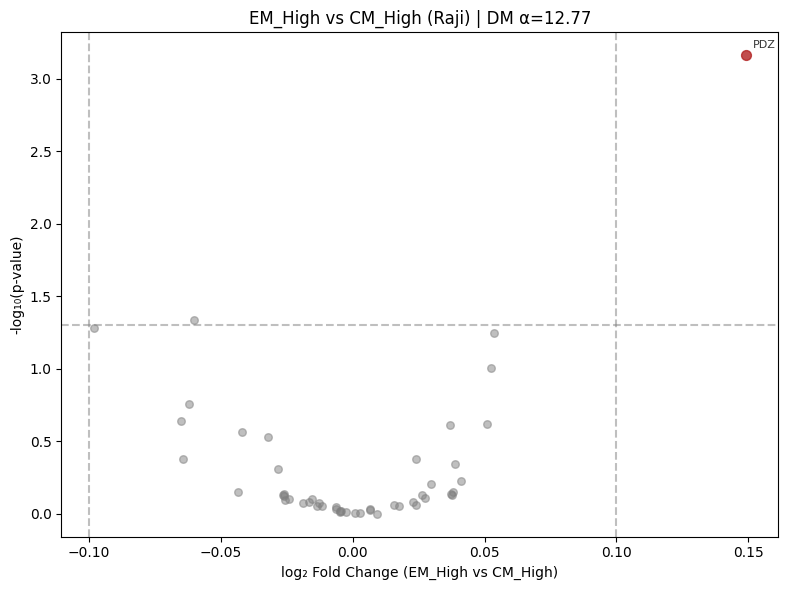

In [12]:
# EM_High vs CM_High
res_em_cm_high = dm_volcano_plot(
    dm_result, dm_data,
    phenotype_p="EM_High",
    phenotype_q="CM_High",
    q_thresh=0.10,
    lfc_thresh=0.1,
    title=f"EM_High vs CM_High (Raji) | DM α={dm_result.alpha:.2f}",
    outpath=results_path / "volcano_EM_High_vs_CM_High.png",
)
res_em_cm_high.to_csv(results_path / "volcano_table_EM_High_vs_CM_High.csv", index=False)

/var/folders/sg/l4rlr1v176s_kr7034qn49900000gn/T/ipykernel_55748/2789645540.py:84: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/sg/l4rlr1v176s_kr7034qn49900000gn/T/ipykernel_55748/2789645540.py:84: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/sg/l4rlr1v176s_kr7034qn49900000gn/T/ipykernel_55748/2789645540.py:84: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/sg/l4rlr1v176s_kr7034qn49900000gn/T/ipykernel_55748/2789645540.py:87: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.savefig(outpath, dpi=300, bbox_inches="tight")
/var/folders/sg/l4rlr1v176s_kr7034qn49900000gn/T/ipykernel_55748/2789645540.py:87: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  fig.savefig(outpath, dpi=300, bbox_inches="tight")
/var/folders/sg/l4rlr1v176s_kr7034qn49900000gn/T/ipyker

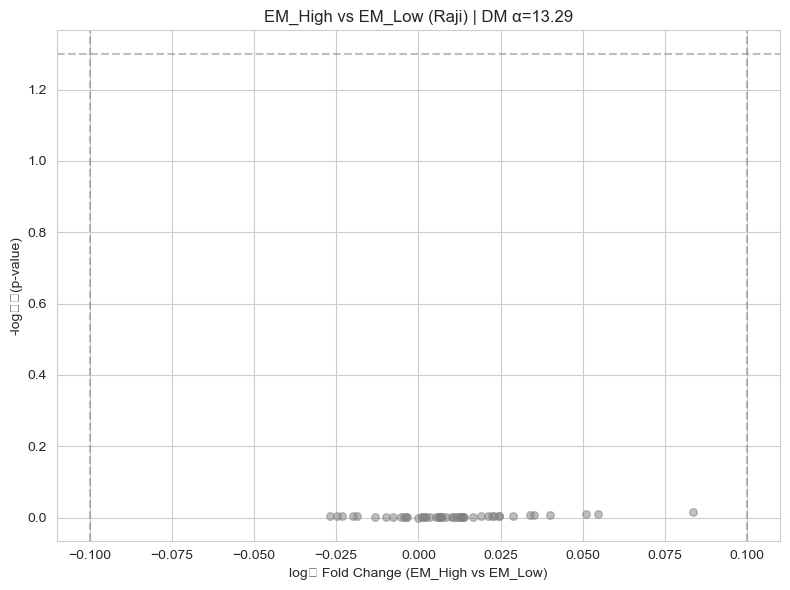

In [12]:
# EM_High vs EM_Low (PD1 effect within EM)
res_em_pd1 = dm_volcano_plot(
    dm_result, dm_data,
    phenotype_p="EM_High",
    phenotype_q="EM_Low",
    q_thresh=0.10,
    lfc_thresh=0.1,
    title=f"EM_High vs EM_Low (Raji) | DM α={dm_result.alpha:.2f}",
    outpath=results_path / "volcano_EM_High_vs_EM_Low.png",
)
res_em_pd1.to_csv(results_path / "volcano_table_EM_High_vs_EM_Low.csv", index=False)

## Pooled Contrasts (T-subset pooled over PD1)

In [ ]:
def dm_pooled_tsubset_contrast(
    dm_result,
    dm_data,
    tsubset_p,
    tsubset_q,
    q_thresh=0.10,
    lfc_thresh=0.1,
    title=None,
    top_n_labels=12,
    outpath=None,
    figsize=(8, 6),
):
    """
    Pooled T-subset contrast: average effect across PD1 levels.
    
    Computes: 0.5 * (tsubset_p_High - tsubset_q_High) + 0.5 * (tsubset_p_Low - tsubset_q_Low)
    Uses proper covariance-aware standard errors.
    """
    records = []
    
    # Build contrast weights: 0.5 for each phenotype of tsubset_p, -0.5 for tsubset_q
    weights = {}
    for pd1 in ["High", "Low"]:
        weights[f"{tsubset_p}_{pd1}"] = 0.5
        weights[f"{tsubset_q}_{pd1}"] = -0.5
    
    for elm_name in dm_data.elm_names:
        # Use wald_contrast for proper covariance-aware SE
        effect, se, pval = dm_result.wald_contrast(elm_name, weights)
        
        records.append({
            "motif": elm_name,
            "log2FC": effect / np.log(2),
            "pvalue": pval,
            "z": effect / se if se > 0 else 0,
        })
    
    res = pd.DataFrame(records)
    res["qvalue"] = cs.bh_fdr(res["pvalue"])
    res["-log10p"] = -np.log10(res["pvalue"].clip(lower=1e-300))
    
    # Plot
    fig, ax = plt.subplots(figsize=figsize)
    
    sig_mask = (res["qvalue"] < q_thresh) & (abs(res["log2FC"]) > lfc_thresh)
    
    ax.scatter(
        res.loc[~sig_mask, "log2FC"],
        res.loc[~sig_mask, "-log10p"],
        c="gray", alpha=0.5, s=30, label="NS"
    )
    
    colors = np.where(res.loc[sig_mask, "log2FC"] > 0, "firebrick", "steelblue")
    ax.scatter(
        res.loc[sig_mask, "log2FC"],
        res.loc[sig_mask, "-log10p"],
        c=colors, alpha=0.8, s=50, label=f"FDR < {q_thresh}"
    )
    
    ax.axhline(-np.log10(0.05), color="gray", linestyle="--", alpha=0.5)
    ax.axvline(-lfc_thresh, color="gray", linestyle="--", alpha=0.5)
    ax.axvline(lfc_thresh, color="gray", linestyle="--", alpha=0.5)
    
    top_hits = res[sig_mask].nlargest(top_n_labels, "-log10p")
    for _, row in top_hits.iterrows():
        ax.annotate(
            row["motif"].replace("ELM_", ""),
            (row["log2FC"], row["-log10p"]),
            fontsize=8,
            alpha=0.8,
            xytext=(5, 5),
            textcoords="offset points",
        )
    
    # Use mathtext for subscripts to avoid font warnings
    ax.set_xlabel(rf"$\log_2$ Fold Change ({tsubset_p} vs {tsubset_q}, pooled PD1)")
    ax.set_ylabel(r"-$\log_{10}$(p-value)")
    if title:
        ax.set_title(title)
    else:
        ax.set_title(f"{tsubset_p} vs {tsubset_q} (pooled over PD1)")
    
    plt.tight_layout()
    
    if outpath:
        fig.savefig(outpath, dpi=300, bbox_inches="tight")
    
    plt.show()
    
    return res

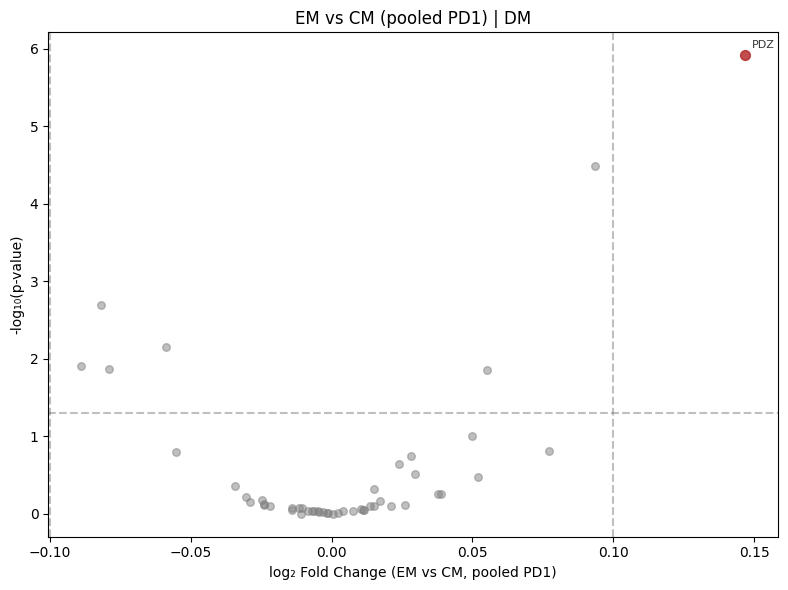

In [15]:
# EM vs CM (pooled over PD1)
res_em_cm = dm_pooled_tsubset_contrast(
    dm_result, dm_data,
    tsubset_p="EM",
    tsubset_q="CM",
    q_thresh=0.10,
    lfc_thresh=0.1,
    title=f"EM vs CM (pooled PD1) | DM",
    outpath=results_path / "volcano_EM_vs_CM_pooledPD1.png",
)
res_em_cm.to_csv(results_path / "table_EM_vs_CM_pooledPD1.csv", index=False)

/var/folders/sg/l4rlr1v176s_kr7034qn49900000gn/T/ipykernel_55748/4164845842.py:82: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/sg/l4rlr1v176s_kr7034qn49900000gn/T/ipykernel_55748/4164845842.py:82: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/sg/l4rlr1v176s_kr7034qn49900000gn/T/ipykernel_55748/4164845842.py:82: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/sg/l4rlr1v176s_kr7034qn49900000gn/T/ipykernel_55748/4164845842.py:85: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.savefig(outpath, dpi=300, bbox_inches="tight")
/var/folders/sg/l4rlr1v176s_kr7034qn49900000gn/T/ipykernel_55748/4164845842.py:85: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  fig.savefig(outpath, dpi=300, bbox_inches="tight")
/var/folders/sg/l4rlr1v176s_kr7034qn49900000gn/T/ipyker

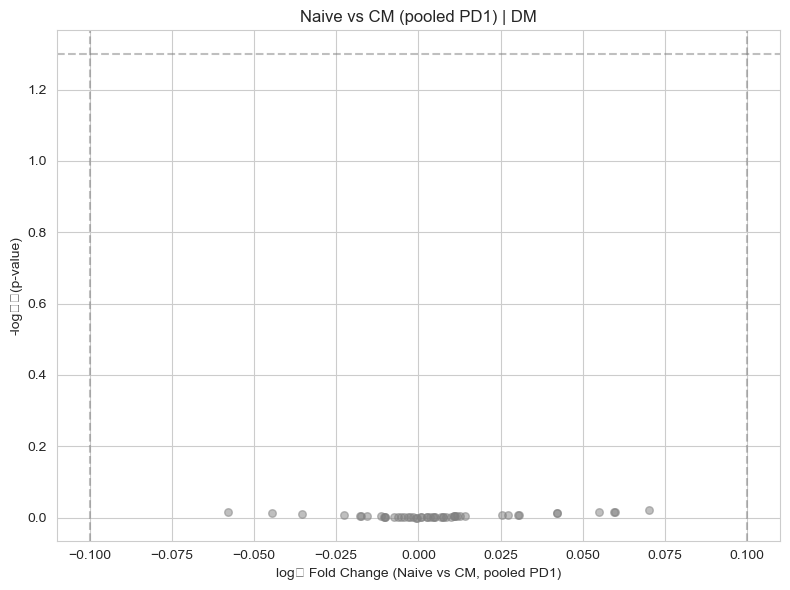

In [15]:
# Naive vs CM (pooled over PD1)
res_naive_cm = dm_pooled_tsubset_contrast(
    dm_result, dm_data,
    tsubset_p="Naive",
    tsubset_q="CM",
    q_thresh=0.10,
    lfc_thresh=0.1,
    title=f"Naive vs CM (pooled PD1) | DM",
    outpath=results_path / "volcano_Naive_vs_CM_pooledPD1.png",
)
res_naive_cm.to_csv(results_path / "table_Naive_vs_CM_pooledPD1.csv", index=False)

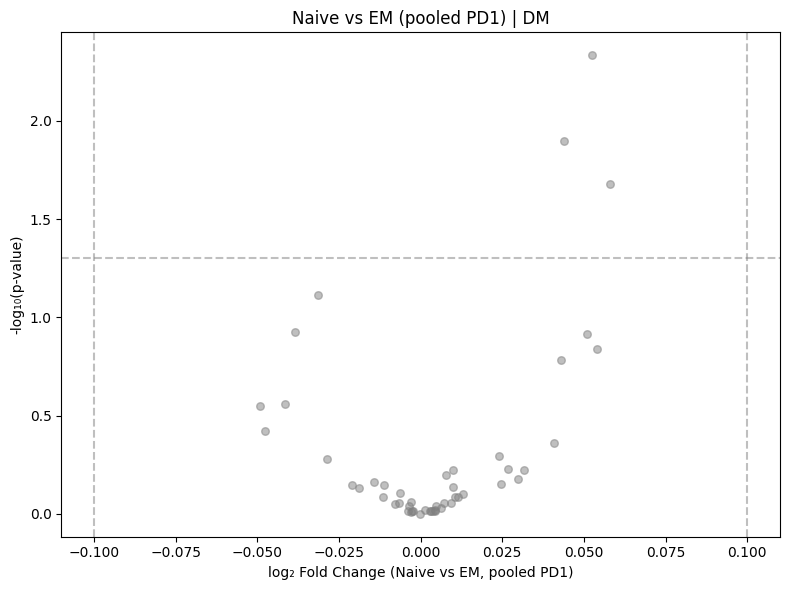

In [17]:
# Naive vs EM (pooled over PD1)
res_naive_em = dm_pooled_tsubset_contrast(
    dm_result, dm_data,
    tsubset_p="Naive",
    tsubset_q="EM",
    q_thresh=0.10,
    lfc_thresh=0.1,
    title=f"Naive vs EM (pooled PD1) | DM",
    outpath=results_path / "volcano_Naive_vs_EM_pooledPD1.png",
)
res_naive_em.to_csv(results_path / "table_Naive_vs_EM_pooledPD1.csv", index=False)

## PD1 Contrast (Pooled over T-subsets)

In [ ]:
def dm_pooled_pd1_contrast(
    dm_result,
    dm_data,
    pd1_high="Low",
    pd1_low="High",
    tsubsets=("Naive", "CM", "EM"),
    q_thresh=0.10,
    lfc_thresh=0.1,
    title=None,
    top_n_labels=12,
    outpath=None,
    figsize=(8, 6),
):
    """
    Pooled PD1 contrast: average effect across T-subsets.
    Uses proper covariance-aware standard errors.
    """
    records = []
    n_tsubsets = len(tsubsets)
    
    # Build contrast weights: (1/n) for each PD1_high phenotype, -(1/n) for each PD1_low
    weights = {}
    for ts in tsubsets:
        weights[f"{ts}_{pd1_high}"] = 1.0 / n_tsubsets
        weights[f"{ts}_{pd1_low}"] = -1.0 / n_tsubsets
    
    for elm_name in dm_data.elm_names:
        # Use wald_contrast for proper covariance-aware SE
        effect, se, pval = dm_result.wald_contrast(elm_name, weights)
        
        records.append({
            "motif": elm_name,
            "log2FC": effect / np.log(2),
            "pvalue": pval,
            "z": effect / se if se > 0 else 0,
        })
    
    res = pd.DataFrame(records)
    res["qvalue"] = cs.bh_fdr(res["pvalue"])
    res["-log10p"] = -np.log10(res["pvalue"].clip(lower=1e-300))
    
    # Plot
    fig, ax = plt.subplots(figsize=figsize)
    
    sig_mask = (res["qvalue"] < q_thresh) & (abs(res["log2FC"]) > lfc_thresh)
    
    ax.scatter(
        res.loc[~sig_mask, "log2FC"],
        res.loc[~sig_mask, "-log10p"],
        c="gray", alpha=0.5, s=30, label="NS"
    )
    
    colors = np.where(res.loc[sig_mask, "log2FC"] > 0, "firebrick", "steelblue")
    ax.scatter(
        res.loc[sig_mask, "log2FC"],
        res.loc[sig_mask, "-log10p"],
        c=colors, alpha=0.8, s=50, label=f"FDR < {q_thresh}"
    )
    
    ax.axhline(-np.log10(0.05), color="gray", linestyle="--", alpha=0.5)
    ax.axvline(-lfc_thresh, color="gray", linestyle="--", alpha=0.5)
    ax.axvline(lfc_thresh, color="gray", linestyle="--", alpha=0.5)
    
    top_hits = res[sig_mask].nlargest(top_n_labels, "-log10p")
    for _, row in top_hits.iterrows():
        ax.annotate(
            row["motif"].replace("ELM_", ""),
            (row["log2FC"], row["-log10p"]),
            fontsize=8,
            alpha=0.8,
            xytext=(5, 5),
            textcoords="offset points",
        )
    
    # Use mathtext for subscripts to avoid font warnings
    ax.set_xlabel(rf"$\log_2$ Fold Change (PD1 {pd1_high} vs {pd1_low}, pooled T-subsets)")
    ax.set_ylabel(r"-$\log_{10}$(p-value)")
    if title:
        ax.set_title(title)
    else:
        ax.set_title(f"PD1 {pd1_high} vs {pd1_low} (pooled over T-subsets)")
    
    plt.tight_layout()
    
    if outpath:
        fig.savefig(outpath, dpi=300, bbox_inches="tight")
    
    plt.show()
    
    return res

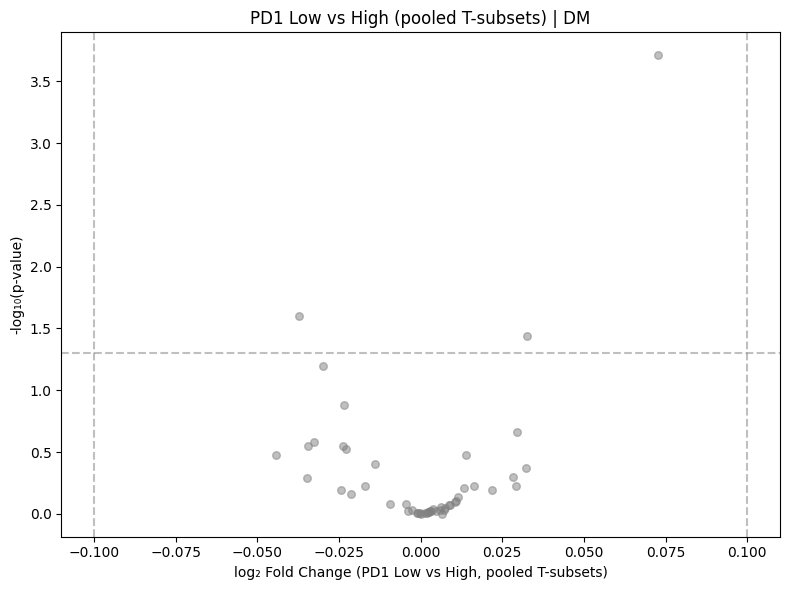

In [19]:
# PD1 Low vs High (pooled over T-subsets)
res_pd1 = dm_pooled_pd1_contrast(
    dm_result, dm_data,
    pd1_high="Low",
    pd1_low="High",
    q_thresh=0.10,
    lfc_thresh=0.1,
    title=f"PD1 Low vs High (pooled T-subsets) | DM",
    outpath=results_path / "volcano_PD1Low_vs_PD1High_pooledTsubset.png",
)
res_pd1.to_csv(results_path / "table_PD1Low_vs_PD1High_pooledTsubset.csv", index=False)

# Coefficient Heatmap

In [20]:
def dm_coef_heatmap(
    dm_result,
    dm_data,
    value="z",
    title=None,
    outpath=None,
    figsize=(10, 12),
):
    """
    Heatmap of ELM effects across phenotypes.
    """
    ref_phenotype = dm_result.reference_phenotype
    non_ref_phenotypes = dm_result.non_ref_phenotypes
    
    # Build matrix
    data = []
    for elm_idx, elm_name in enumerate(dm_data.elm_names):
        row = {"ELM": elm_name}
        
        for phen in non_ref_phenotypes:
            eff, se = dm_result.get_elm_effect(elm_name, phen)
            z = eff / se if se > 0 else 0
            
            if value == "z":
                row[phen] = z
            elif value == "effect":
                row[phen] = eff
            elif value == "log2FC":
                row[phen] = eff / np.log(2)
        
        data.append(row)
    
    df = pd.DataFrame(data).set_index("ELM")
    
    # Sort by max absolute value
    df = df.loc[df.abs().max(axis=1).sort_values(ascending=False).index]
    
    # Plot
    fig, ax = plt.subplots(figsize=figsize)
    
    vmax = df.abs().values.max()
    vmin = -vmax
    
    sns.heatmap(
        df,
        cmap="RdBu_r",
        center=0,
        vmin=vmin,
        vmax=vmax,
        ax=ax,
        cbar_kws={"label": value},
    )
    
    ax.set_xlabel("Phenotype")
    ax.set_ylabel("ELM")
    
    # Clean up ELM names
    ax.set_yticklabels([t.get_text().replace("ELM_", "") for t in ax.get_yticklabels()], fontsize=8)
    
    if title:
        ax.set_title(title)
    
    plt.tight_layout()
    
    if outpath:
        fig.savefig(outpath, dpi=300, bbox_inches="tight")
    
    plt.show()
    
    return fig, ax, df

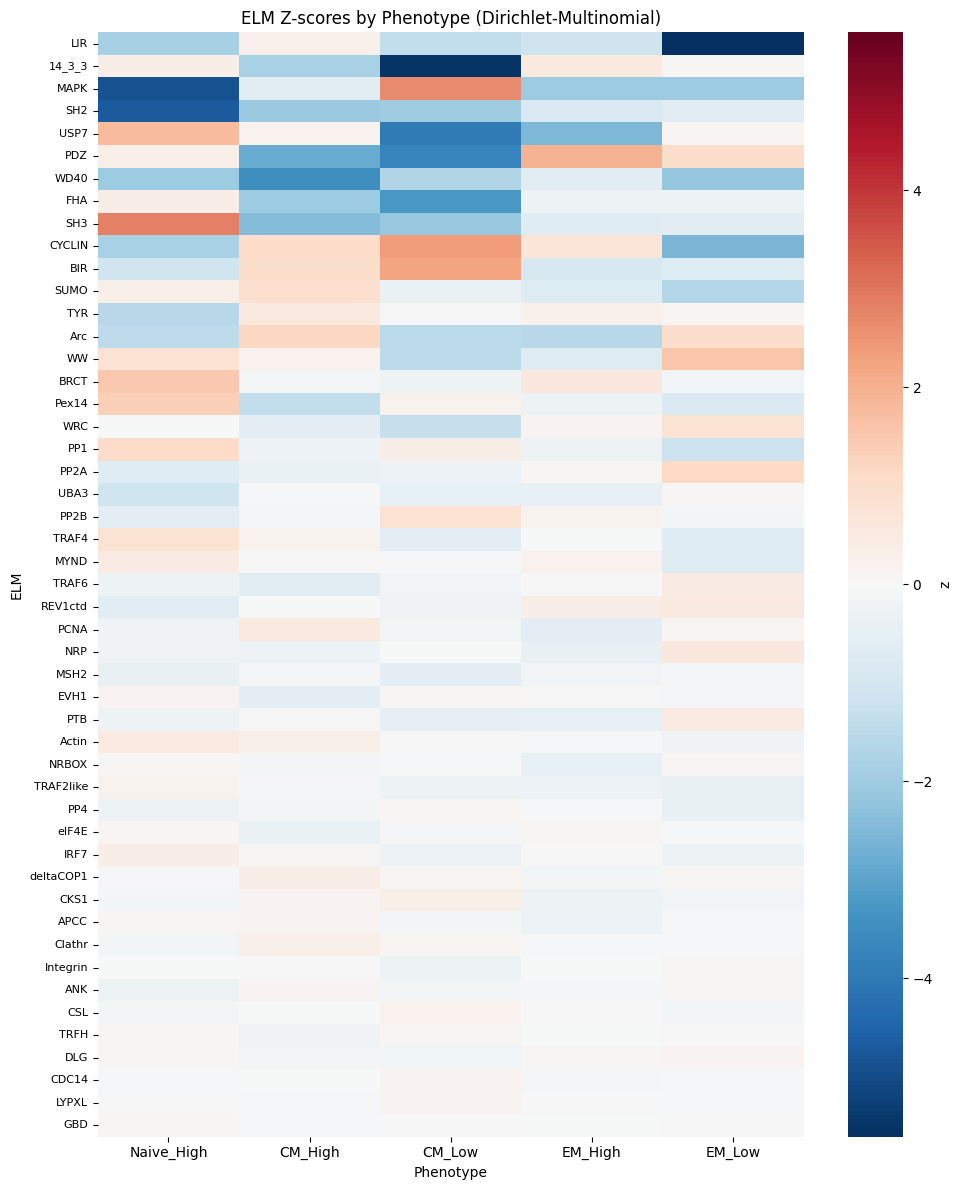

In [21]:
fig, ax, heatmap_data = dm_coef_heatmap(
    dm_result, dm_data,
    value="z",
    title="ELM Z-scores by Phenotype (Dirichlet-Multinomial)",
    outpath=results_path / "heatmap_z_scores.png",
)
heatmap_data.to_csv(results_path / "heatmap_z_scores.csv")

## Pooled Heatmap (T-subset effects pooled over PD1)

In [22]:
def dm_pooled_heatmap(
    dm_result,
    dm_data,
    include_pd1_low=True,
    title=None,
    outpath=None,
    figsize=(6, 12),
):
    """
    Heatmap with pooled phenotypes: Naive, CM, EM (pooled over PD1) and optionally PD1_Low.
    """
    ref_phenotype = dm_result.reference_phenotype
    tsubsets = ["Naive", "CM", "EM"]
    
    data = []
    for elm_idx, elm_name in enumerate(dm_data.elm_names):
        row = {"ELM": elm_name}
        
        # Pooled T-subset effects
        for ts in tsubsets:
            eff_high, se_high = dm_result.get_elm_effect(elm_name, f"{ts}_High") if f"{ts}_High" != ref_phenotype else (0, 0)
            eff_low, se_low = dm_result.get_elm_effect(elm_name, f"{ts}_Low") if f"{ts}_Low" != ref_phenotype else (0, 0)
            
            pooled_eff = 0.5 * (eff_high + eff_low)
            pooled_se = 0.5 * np.sqrt(se_high**2 + se_low**2)
            pooled_z = pooled_eff / pooled_se if pooled_se > 0 else 0
            
            row[ts] = pooled_z
        
        # PD1_Low pooled over T-subsets
        if include_pd1_low:
            pd1_eff = 0
            pd1_var = 0
            for ts in tsubsets:
                eff_low, se_low = dm_result.get_elm_effect(elm_name, f"{ts}_Low") if f"{ts}_Low" != ref_phenotype else (0, 0)
                eff_high, se_high = dm_result.get_elm_effect(elm_name, f"{ts}_High") if f"{ts}_High" != ref_phenotype else (0, 0)
                pd1_eff += (1/3) * (eff_low - eff_high)
                pd1_var += (1/9) * (se_low**2 + se_high**2)
            
            pd1_se = np.sqrt(pd1_var)
            pd1_z = pd1_eff / pd1_se if pd1_se > 0 else 0
            row["PD1_Low"] = pd1_z
        
        data.append(row)
    
    df = pd.DataFrame(data).set_index("ELM")
    
    # Sort by max absolute value
    df = df.loc[df.abs().max(axis=1).sort_values(ascending=False).index]
    
    # Plot
    fig, ax = plt.subplots(figsize=figsize)
    
    vmax = df.abs().values.max()
    vmin = -vmax
    
    sns.heatmap(
        df,
        cmap="RdBu_r",
        center=0,
        vmin=vmin,
        vmax=vmax,
        ax=ax,
        cbar_kws={"label": "Z-score"},
    )
    
    ax.set_xlabel("Pooled Phenotype")
    ax.set_ylabel("ELM")
    ax.set_yticklabels([t.get_text().replace("ELM_", "") for t in ax.get_yticklabels()], fontsize=8)
    
    if title:
        ax.set_title(title)
    
    plt.tight_layout()
    
    if outpath:
        fig.savefig(outpath, dpi=300, bbox_inches="tight")
    
    plt.show()
    
    return fig, ax, df

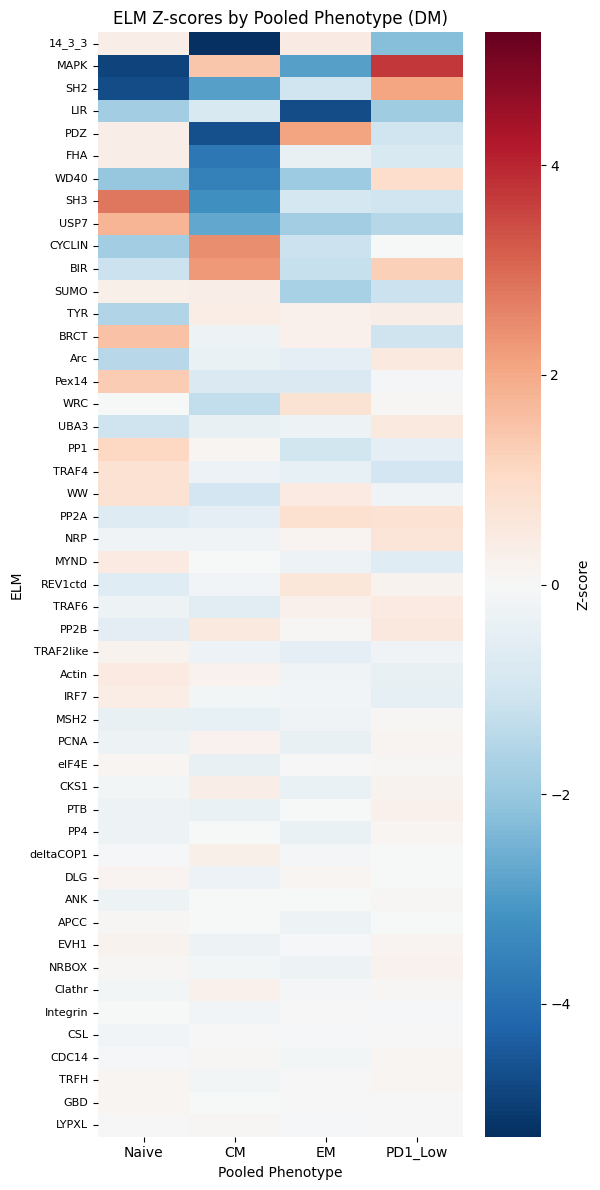

In [23]:
fig, ax, pooled_data = dm_pooled_heatmap(
    dm_result, dm_data,
    include_pd1_low=True,
    title="ELM Z-scores by Pooled Phenotype (DM)",
    outpath=results_path / "heatmap_pooled.png",
)
pooled_data.to_csv(results_path / "heatmap_pooled.csv")

## Assemble Main Figure

In [24]:
import matplotlib.image as mpimg

def assemble_dm_main_figure(
    results_path,
    *,
    volcano_em_vs_cm="volcano_EM_vs_CM_pooledPD1.png",
    volcano_naive_vs_cm="volcano_Naive_vs_CM_pooledPD1.png",
    volcano_naive_vs_em="volcano_Naive_vs_EM_pooledPD1.png",
    volcano_pd1low_vs_high="volcano_PD1Low_vs_PD1High_pooledTsubset.png",
    heatmap_pooled="heatmap_pooled.png",
    out_png="figure_dm_volcanos_plus_heatmap.png",
    out_pdf="figure_dm_volcanos_plus_heatmap.pdf",
    dpi=300,
    width_ratios=(4.0, 1.2),
):
    results_path = Path(results_path)
    paths = {
        "A": results_path / volcano_em_vs_cm,
        "B": results_path / volcano_naive_vs_cm,
        "C": results_path / volcano_naive_vs_em,
        "D": results_path / volcano_pd1low_vs_high,
        "E": results_path / heatmap_pooled,
    }

    missing = [k for k, p in paths.items() if not p.exists()]
    if missing:
        raise FileNotFoundError(
            "Missing expected figure files:\n"
            + "\n".join([f"  {k}: {paths[k]}" for k in missing])
        )

    imgs = {k: mpimg.imread(str(p)) for k, p in paths.items()}

    fig = plt.figure(figsize=(14, 8))
    outer = fig.add_gridspec(
        nrows=2, ncols=2,
        width_ratios=list(width_ratios),
        height_ratios=[1, 1],
        wspace=0.02, hspace=0.05,
    )

    left = outer[:, 0].subgridspec(nrows=2, ncols=2, wspace=0.05, hspace=0.08)

    axA = fig.add_subplot(left[0, 0])
    axB = fig.add_subplot(left[0, 1])
    axC = fig.add_subplot(left[1, 0])
    axD = fig.add_subplot(left[1, 1])
    axE = fig.add_subplot(outer[:, 1])

    for ax, key in [(axA,"A"), (axB,"B"), (axC,"C"), (axD,"D"), (axE,"E")]:
        ax.imshow(imgs[key])
        ax.axis("off")
        ax.text(
            0.01, 0.99, key,
            transform=ax.transAxes,
            ha="left", va="top",
            fontweight="bold",
            fontsize=14,
        )

    out_png_path = results_path / out_png
    fig.savefig(out_png_path, dpi=dpi, bbox_inches="tight")
    if out_pdf is not None:
        fig.savefig(results_path / out_pdf, bbox_inches="tight")
    plt.close(fig)

    return out_png_path

out_path = assemble_dm_main_figure(results_path)
print(f"Main figure saved to: {out_path}")

Main figure saved to: /sessions/great-zealous-thompson/mnt/Costim screen analysis/results/dm_analysis/figure_dm_volcanos_plus_heatmap.png


# Summary

This notebook applied the Dirichlet-Multinomial model to the CAR:Raji costimulatory screen data.

**Key outputs:**
- `dm_all_effects.csv` - Full table of ELM effects and p-values
- Volcano plots for pairwise phenotype contrasts
- Volcano plots for pooled T-subset and PD1 contrasts
- Coefficient heatmaps
- Combined main figure

**Model interpretation:**
- Effects are on the log-odds scale relative to Naive_Low (reference)
- Positive effect = increased probability of that phenotype
- The concentration parameter α controls overdispersion (larger α = less variance)